# **Spark으로 PCA** 

In [ ]:
# code for loading the format for the notebook
import os

# path : store the current path to convert back to it later
path = os.getcwd()

In [ ]:
pip install "watermark==2.0.2"

  Using cached https://files.pythonhosted.org/packages/60/fe/3ed83b6122e70dce6fe269dfd763103c333f168bf91037add73ea4fe81c2/watermark-2.0.2-py2.py3-none-any.whl
  Found existing installation: watermark 2.2.0
    Can't uninstall 'watermark'. No files were found to uninstall.


In [ ]:
pip install -e git+https://github.com/rasbt/watermark#egg=watermark

Obtaining watermark from git+https://github.com/rasbt/watermark#egg=watermark
  Updating ./src/watermark clone
  Running command git fetch -q --tags
  Running command git reset --hard -q d3553b68dd30ac5b0951a6fae6083236e4c7f3bd
  Found existing installation: watermark 2.0.2
    Uninstalling watermark-2.0.2:
      Successfully uninstalled watermark-2.0.2
  Running setup.py develop for watermark


In [ ]:
pip install pyspark

In [ ]:
 import sys
 !conda install --yes --prefix {sys.prefix} watermark

/bin/bash: conda: command not found


In [ ]:
os.chdir(path)

%matplotlib inline
%load_ext watermark
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
%watermark -v -p numpy,scipy,sklearn,pandas,matplotlib


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from pyspark.conf import SparkConf
from pyspark.sql import SparkSession 
from pyspark.ml.feature import VectorAssembler, StandardScaler, PCA

# create the SparkSession class,
# which is the entry point into all functionality in Spark
# The .master part sets it to run on all cores on local, note
# that we should leave out the .master part if we're actually
# running the job on a cluster, or else we won't be actually
# using the cluster
spark = (SparkSession.
         builder.
         master('local[*]').
         appName('PCA').
         config(conf = SparkConf()).
         getOrCreate())

%watermark -a 'Ethen' -d -t -v -p numpy,pandas,matplotlib,sklearn,pyspark

Python implementation: CPython
Python version       : 3.7.10
IPython version      : 5.5.0

numpy     : 1.19.5
scipy     : 1.4.1
sklearn   : 0.0
pandas    : 1.1.5
matplotlib: 3.2.2

Author: Ethen

Python implementation: CPython
Python version       : 3.7.10
IPython version      : 5.5.0

numpy     : 1.19.5
pandas    : 1.1.5
matplotlib: 3.2.2
sklearn   : 0.0
pyspark   : 3.1.1



**ombine a given list of columns into a single vector column**

In [ ]:
# specify the input columns' name and
# the combined output column's name
assembler = VectorAssembler(
    inputCols = iris.feature_names, outputCol = 'features')

# use it to transform the dataset and select just
# the output column
df = assembler.transform(dataset).select('features')
df.show(6)

+-----------------+
|         features|
+-----------------+
|[5.1,3.5,1.4,0.2]|
|[4.9,3.0,1.4,0.2]|
|[4.7,3.2,1.3,0.2]|
|[4.6,3.1,1.5,0.2]|
|[5.0,3.6,1.4,0.2]|
|[5.4,3.9,1.7,0.4]|
+-----------------+
only showing top 6 rows



**standardize the features**

In [ ]:
scaler = StandardScaler(
    inputCol = 'features', 
    outputCol = 'scaledFeatures',
    withMean = True,
    withStd = True
).fit(df)

# when we transform the dataframe, the old
# feature will still remain in it
df_scaled = scaler.transform(df)
df_scaled.show(6)

+-----------------+--------------------+
|         features|      scaledFeatures|
+-----------------+--------------------+
|[5.1,3.5,1.4,0.2]|[-0.8976738791967...|
|[4.9,3.0,1.4,0.2]|[-1.1392004834649...|
|[4.7,3.2,1.3,0.2]|[-1.3807270877331...|
|[4.6,3.1,1.5,0.2]|[-1.5014903898672...|
|[5.0,3.6,1.4,0.2]|[-1.0184371813308...|
|[5.4,3.9,1.7,0.4]|[-0.5353839727944...|
+-----------------+--------------------+
only showing top 6 rows



**fit the PCA model**

In [ ]:
n_components = 2
pca = PCA(
    k = n_components, 
    inputCol = 'scaledFeatures', 
    outputCol = 'pcaFeatures'
).fit(df_scaled)

df_pca = pca.transform(df_scaled)
print('Explained Variance Ratio', pca.explainedVariance.toArray())
df_pca.show(6)

Explained Variance Ratio [0.72962445 0.22850762]
+-----------------+--------------------+--------------------+
|         features|      scaledFeatures|         pcaFeatures|
+-----------------+--------------------+--------------------+
|[5.1,3.5,1.4,0.2]|[-0.8976738791967...|[2.25714117564811...|
|[4.9,3.0,1.4,0.2]|[-1.1392004834649...|[2.07401301519962...|
|[4.7,3.2,1.3,0.2]|[-1.3807270877331...|[2.35633511180617...|
|[4.6,3.1,1.5,0.2]|[-1.5014903898672...|[2.29170678586969...|
|[5.0,3.6,1.4,0.2]|[-1.0184371813308...|[2.38186270441693...|
|[5.4,3.9,1.7,0.4]|[-0.5353839727944...|[2.06870060846769...|
+-----------------+--------------------+--------------------+
only showing top 6 rows



In [ ]:
# not sure if this is the best way to do it
X_pca = df_pca.rdd.map(lambda row: row.pcaFeatures).collect()
X_pca = np.array(X_pca)

In [ ]:
# change default style figure and font size
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = 8, 6
plt.rcParams['font.size'] = 12


def plot_iris_pca(X_pca, y):
    """a scatter plot of the 2-dimensional iris data"""
    markers = 's', 'x', 'o'
    colors = list(plt.rcParams['axes.prop_cycle'])
    target = np.unique(y)
    for idx, (t, m) in enumerate(zip(target, markers)):
        subset = X_pca[y == t]
        plt.scatter(subset[:, 0], subset[:, 1], s = 50,
                    c = colors[idx]['color'], label = t, marker = m)

    plt.xlabel('PC 1')
    plt.ylabel('PC 2')
    plt.legend(loc = 'lower left')
    plt.tight_layout()
    plt.show()

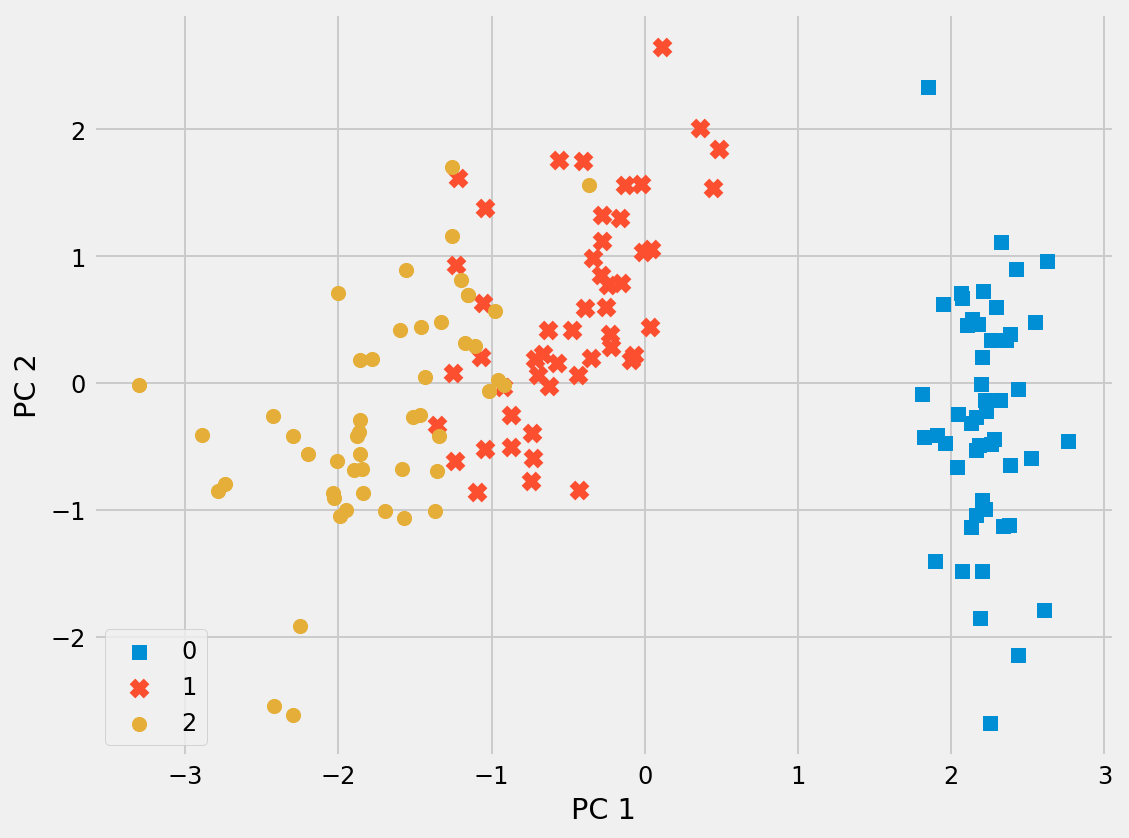

In [ ]:
plot_iris_pca(X_pca, y)

In [ ]:
# stop the current sparkSession
spark.stop()

**Time 비교**

In [ ]:
# time 비교

%%time
# load the data and convert it to a pandas DataFrame,
# then use that to create the spark DataFrame
iris = load_iris()
X = iris['data']
y = iris['target']

data = pd.DataFrame(X, columns = iris.feature_names)
dataset = spark.createDataFrame(data, iris.feature_names)
dataset.show(6)

# specify the input columns' name and
# the combined output column's name
assembler = VectorAssembler(
    inputCols = iris.feature_names, outputCol = 'features')

# use it to transform the dataset and select just
# the output column
df = assembler.transform(dataset).select('features')
df.show(6)

scaler = StandardScaler(
    inputCol = 'features', 
    outputCol = 'scaledFeatures',
    withMean = True,
    withStd = True
).fit(df)

# when we transform the dataframe, the old
# feature will still remain in it
df_scaled = scaler.transform(df)
df_scaled.show(6)

n_components = 2
pca = PCA(
    k = n_components, 
    inputCol = 'scaledFeatures', 
    outputCol = 'pcaFeatures'
).fit(df_scaled)

df_pca = pca.transform(df_scaled)
print('Explained Variance Ratio', pca.explainedVariance.toArray())
df_pca.show(6)

# not sure if this is the best way to do it
X_pca = df_pca.rdd.map(lambda row: row.pcaFeatures).collect()
X_pca = np.array(X_pca)

+-----------------+----------------+-----------------+----------------+
|sepal length (cm)|sepal width (cm)|petal length (cm)|petal width (cm)|
+-----------------+----------------+-----------------+----------------+
|              5.1|             3.5|              1.4|             0.2|
|              4.9|             3.0|              1.4|             0.2|
|              4.7|             3.2|              1.3|             0.2|
|              4.6|             3.1|              1.5|             0.2|
|              5.0|             3.6|              1.4|             0.2|
|              5.4|             3.9|              1.7|             0.4|
+-----------------+----------------+-----------------+----------------+
only showing top 6 rows

+-----------------+
|         features|
+-----------------+
|[5.1,3.5,1.4,0.2]|
|[4.9,3.0,1.4,0.2]|
|[4.7,3.2,1.3,0.2]|
|[4.6,3.1,1.5,0.2]|
|[5.0,3.6,1.4,0.2]|
|[5.4,3.9,1.7,0.4]|
+-----------------+
only showing top 6 rows

+-----------------+-----------

# **파이썬으로 PCA**

**데이터 불러오기**

In [ ]:
import pandas as pd
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data"
df = pd.read_csv(url, names=['sepal length','sepal width','petal length','petal width','target'])
df.head()

,sepal length,sepal width,petal length,petal width,target
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


**표준화**

In [ ]:
from sklearn.preprocessing import StandardScaler  # 표준화 패키지 라이브러리 
x = df.drop(['target'], axis=1).values # 독립변인들의 value값만 추출
y = df['target'].values # 종속변인 추출

x = StandardScaler().fit_transform(x) # x객체에 x를 표준화한 데이터를 저장

features = ['sepal length', 'sepal width', 'petal length', 'petal width']
pd.DataFrame(x, columns=features).head()

,sepal length,sepal width,petal length,petal width
0,-0.900681,1.032057,-1.341272,-1.312977
1,-1.143017,-0.124958,-1.341272,-1.312977
2,-1.385353,0.337848,-1.398138,-1.312977
3,-1.506521,0.106445,-1.284407,-1.312977
4,-1.021849,1.263460,-1.341272,-1.312977


**PCA 실행**

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2) # 주성분을 몇개로 할지 결정
printcipalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data=printcipalComponents, columns = ['principal component1', 'principal component2'])
# 주성분으로 이루어진 데이터 프레임 구성
principalDf.head()
pca.explained_variance_ratio_

array([0.72770452, 0.23030523])

**Time 비교**

In [ ]:
%%time
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data"
df = pd.read_csv(url, names=['sepal length','sepal width','petal length','petal width','target'])
df.head()

x = df.drop(['target'], axis=1).values # 독립변인들의 value값만 추출
y = df['target'].values # 종속변인 추출

x = StandardScaler().fit_transform(x) # x객체에 x를 표준화한 데이터를 저장

features = ['sepal length', 'sepal width', 'petal length', 'petal width']
pd.DataFrame(x, columns=features).head()

pca = PCA(n_components=2) # 주성분을 몇개로 할지 결정
printcipalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data=printcipalComponents, columns = ['principal component1', 'principal component2'])
# 주성분으로 이루어진 데이터 프레임 구성
principalDf.head()
pca.explained_variance_ratio_

CPU times: user 13.5 ms, sys: 1.81 ms, total: 15.3 ms
Wall time: 939 ms
